In [1]:
!pip install gurobipy scikit-learn plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 59.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from gurobipy import Model, GRB
import time
import random
import plotly.express as px

In [3]:
!kaggle datasets download -d mexwell/telecom-shanghai-dataset

Dataset URL: https://www.kaggle.com/datasets/mexwell/telecom-shanghai-dataset
License(s): other
 91%|█████████████████████████████████████    | 198M/219M [00:01<00:00, 205MB/s]
100%|█████████████████████████████████████████| 219M/219M [00:01<00:00, 178MB/s]


In [4]:
!unzip /kaggle/working/telecom-shanghai-dataset.zip

Archive:  /kaggle/working/telecom-shanghai-dataset.zip
  inflating: data_10.110.15.xlsx     
  inflating: data_10.1610.31.xlsx    
  inflating: data_11.111.15.xlsx     
  inflating: data_11.1611.30.xlsx    
  inflating: data_6.16.15.xlsx       
  inflating: data_6.166.30.xlsx      
  inflating: data_7.167.31.xlsx      
  inflating: data_7.17.15.xlsx       
  inflating: data_8.168.31.xlsx      
  inflating: data_8.18.15.xlsx       
  inflating: data_9.169.30.xlsx      
  inflating: data_9.19.15.xlsx       


In [5]:
dir_path = "/kaggle/working/"
df = pd.DataFrame()
for file_name in os.listdir(dir_path):
    if file_name.endswith('.xlsx'):
        file_path = os.path.join(dir_path,file_name)
        
        temp_df = pd.read_excel(file_path,engine='openpyxl')
        df = pd.concat([df,temp_df],ignore_index = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6952921 entries, 0 to 6952920
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   month       int64         
 1   date        int64         
 2   start time  datetime64[ns]
 3   end time    datetime64[ns]
 4   latitude    float64       
 5   longitude   float64       
 6   user id     object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 371.3+ MB


In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6952921 entries, 0 to 6952920
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   month       6952921 non-null  int64         
 1   date        6952921 non-null  int64         
 2   start time  6952921 non-null  datetime64[ns]
 3   end time    6952921 non-null  datetime64[ns]
 4   latitude    6236620 non-null  float64       
 5   longitude   6236620 non-null  float64       
 6   user id     6952921 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 371.3+ MB


In [7]:
df_clean = df.dropna(subset = ['latitude','longitude'])
df_clean['latitude_norm'] = (df['latitude'] - df['latitude'].min()) / (df['latitude'].max() - df['latitude'].min())
df_clean['longitude_norm'] = (df['longitude'] - df['longitude'].min()) / (df['longitude'].max() - df['longitude'].min())
df_clean.info(show_counts=True)
df_clean.head()


/tmp/ipykernel_24/2964709305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['latitude_norm'] = (df['latitude'] - df['latitude'].min()) / (df['latitude'].max() - df['latitude'].min())
/tmp/ipykernel_24/2964709305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['longitude_norm'] = (df['longitude'] - df['longitude'].min()) / (df['longitude'].max() - df['longitude'].min())


<class 'pandas.core.frame.DataFrame'>
Index: 6236620 entries, 196 to 6950027
Data columns (total 9 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   month           6236620 non-null  int64         
 1   date            6236620 non-null  int64         
 2   start time      6236620 non-null  datetime64[ns]
 3   end time        6236620 non-null  datetime64[ns]
 4   latitude        6236620 non-null  float64       
 5   longitude       6236620 non-null  float64       
 6   user id         6236620 non-null  object        
 7   latitude_norm   6236620 non-null  float64       
 8   longitude_norm  6236620 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(2), object(1)
memory usage: 475.8+ MB


,month,date,start time,end time,latitude,longitude,user id,latitude_norm,longitude_norm
196,201408,16,2014-08-16 13:11:06,2014-08-16 13:11:47,31.237872,121.470259,391f9e68e947482f3759d24b066e1f4b,0.351016,0.653051
197,201408,16,2014-08-16 14:27:06,2014-08-16 14:38:00,31.237872,121.470259,1709f1d6ad0d111ecedc9e64ab11437d,0.351016,0.653051
198,201408,16,2014-08-16 14:03:13,2014-08-16 14:03:51,31.237872,121.470259,1709f1d6ad0d111ecedc9e64ab11437d,0.351016,0.653051
199,201408,16,2014-08-16 05:56:16,2014-08-16 06:39:10,31.237872,121.470259,fb6eb0d2c92368a9e9a0585fa95a30d1,0.351016,0.653051
200,201408,16,2014-08-16 08:38:30,2014-08-16 09:26:31,31.237872,121.470259,2edcbeb50cc5721cd533327ef17c4617,0.351016,0.653051


In [8]:
base_stations = df_clean.groupby(['latitude', 'longitude']).size().reset_index(name='workload')
base_stations.info()
base_stations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   3042 non-null   float64
 1   longitude  3042 non-null   float64
 2   workload   3042 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 71.4 KB


,latitude,longitude,workload
0,22.522803,114.218796,4067
1,24.284812,102.999068,3442
2,25.222206,117.086322,849
3,26.139329,103.078562,15338
4,26.215115,109.744661,2754


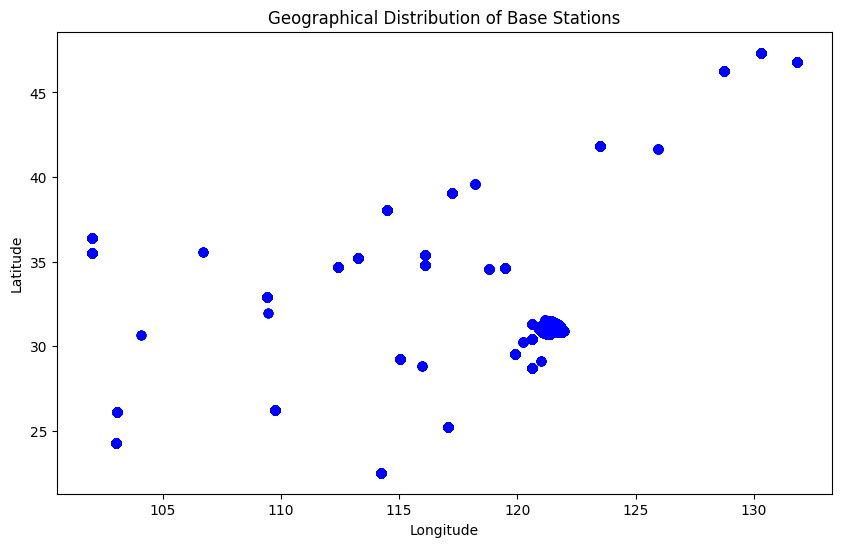

In [9]:
import matplotlib.pyplot as plt

# Geographical scatter plot of base stations
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c='blue', marker='o', alpha=0.5)
plt.title('Geographical Distribution of Base Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


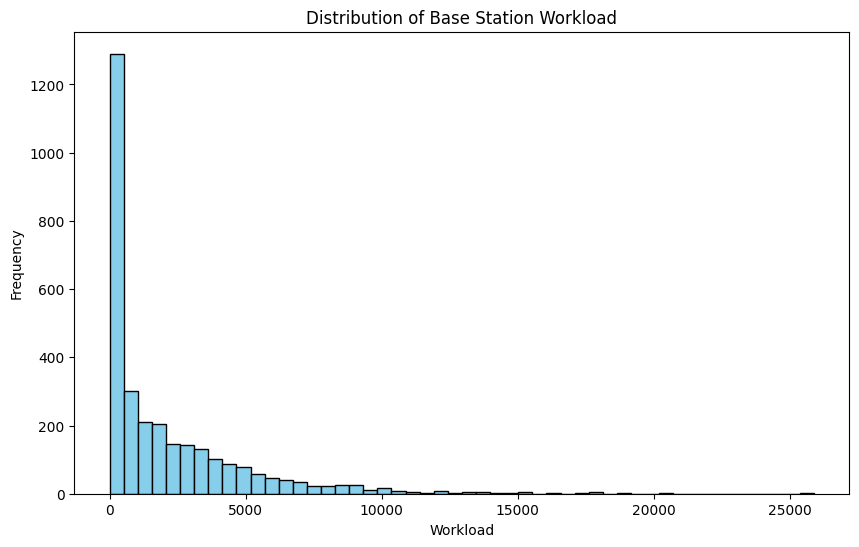

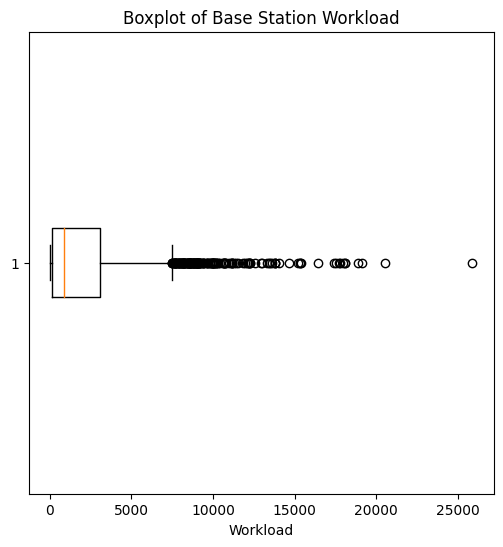

In [10]:
# Workload distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(base_stations['workload'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Base Station Workload')
plt.xlabel('Workload')
plt.ylabel('Frequency')
plt.show()

# Workload boxplot
plt.figure(figsize=(6, 6))
plt.boxplot(base_stations['workload'], vert=False)
plt.title('Boxplot of Base Station Workload')
plt.xlabel('Workload')
plt.show()


In [11]:
fig = px.scatter_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        color="workload",
                        size="workload",  # Bubble size can reflect workload too
                        color_continuous_scale=px.colors.cyclical.IceFire,
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron",  # You can change the map style
                        title="Base Stations Workload Distribution")

fig.show()

In [12]:
fig = px.density_mapbox(base_stations,
                        lat="latitude",
                        lon="longitude",
                        z="workload",  
                        radius=10,  
                        center=dict(lat=31.2304, lon=121.4737),  # Center on Shanghai
                        zoom=10,
                        mapbox_style="stamen-terrain",  
                        title="Heatmap of Base Station Workload")


fig.show()

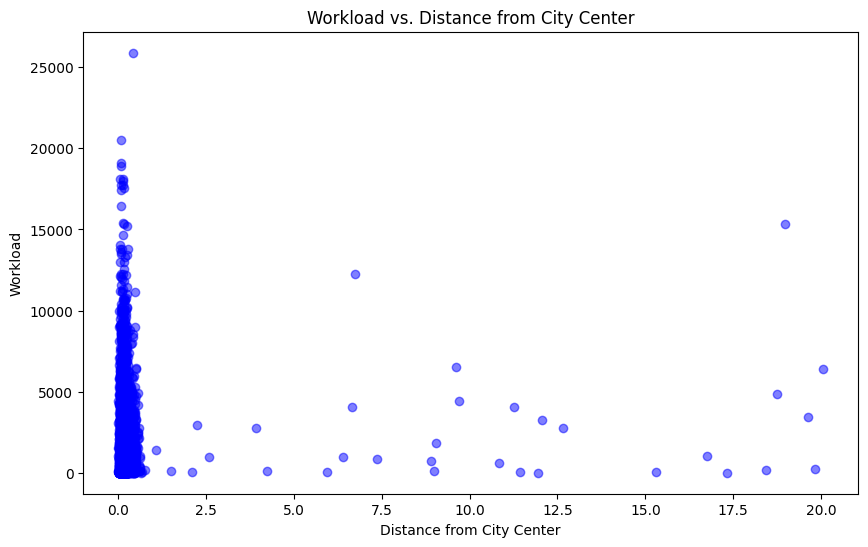

In [13]:

city_center_lat = base_stations['latitude'].mean()
city_center_lon = base_stations['longitude'].mean()


base_stations['distance_to_center'] = np.sqrt((base_stations['latitude'] - city_center_lat)**2 + (base_stations['longitude'] - city_center_lon)**2)


plt.figure(figsize=(10, 6))
plt.scatter(base_stations['distance_to_center'], base_stations['workload'], alpha=0.5, c='blue')
plt.title('Workload vs. Distance from City Center')
plt.xlabel('Distance from City Center')
plt.ylabel('Workload')
plt.show()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/tmp/ipykernel_24/3733570656.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



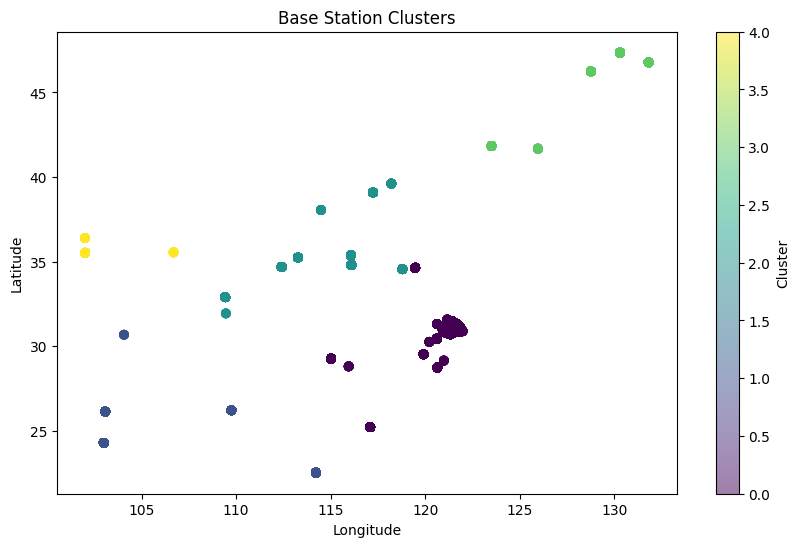

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
df_clean['cluster'] = kmeans.fit_predict(df_clean[['latitude_norm', 'longitude_norm']])

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['longitude'], df_clean['latitude'], c=df_clean['cluster'], cmap='viridis', alpha=0.5)
plt.title('Base Station Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()


In [15]:
base_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3042 entries, 0 to 3041
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   latitude            3042 non-null   float64
 1   longitude           3042 non-null   float64
 2   workload            3042 non-null   int64  
 3   distance_to_center  3042 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 95.2 KB
